In [6]:
import mne
import os
import pandas as pd
import numpy as np
from datetime import datetime, timedelta, timezone

# --- Configuration ---
# Make paths relative to WORKSPACE_ROOT

# Determine paths programmatically instead of hardcoding
WORKSPACE_ROOT = os.getcwd()

# Define experiment details
SAMPLE_DATA_FOLDER = "sample_data"
EXPERIMENT_ID = "E23B6B24FX14_1743611361000"

# Construct file paths
edf_file_path = os.path.join(WORKSPACE_ROOT, SAMPLE_DATA_FOLDER, EXPERIMENT_ID, f"{EXPERIMENT_ID}.edf")
csv_file_path = os.path.join(WORKSPACE_ROOT, SAMPLE_DATA_FOLDER, EXPERIMENT_ID, f"{EXPERIMENT_ID}.csv")

# Print workspace root for verification
print(f"Using workspace root: {WORKSPACE_ROOT}")

# Based on the internal definition in predict_alertness_ema
CHANNELS_FRONTAL = ['LF-FpZ', 'OTE_L-FpZ', 'RF-FpZ', 'OTE_R-FpZ']

print(f"Using CHANNELS_FRONTAL for predict_alertness_ema: {CHANNELS_FRONTAL}")

# --- Load Sleep stages (only the 'Sleep stage' column is needed now) ---
print(f"Loading sleep stages from: {csv_file_path}")
stages_df = pd.read_csv(csv_file_path, usecols=['Sleep stage'])

# --- Load EDF Data ---
print(f"Loading EDF data from: {edf_file_path}")
raw_eeg_full_channels = mne.io.read_raw_edf(edf_file_path, preload=True, verbose='INFO')

# Pick and reorder the necessary channels.
# The `ordered=True` flag ensures they are in the order of CHANNELS_FRONTAL.
# If any channel in CHANNELS_FRONTAL is not found, pick_channels will raise a ValueError.
try:
    raw_eeg = raw_eeg_full_channels.copy().pick_channels(CHANNELS_FRONTAL, ordered=True)
    print(f"Successfully picked and ordered channels: {raw_eeg.ch_names}")
except ValueError as e:
    print(f"Critical Error: Could not pick or order the required channels ({CHANNELS_FRONTAL}). {e}")
    print("Please ensure the EDF file contains these channels or adjust CHANNELS_FRONTAL if the model expects different ones.")
    raise # Stop execution if essential channels are missing

eeg_data = raw_eeg.get_data() # Shape: (len(CHANNELS_FRONTAL), n_samples)
FS_ORIGINAL = int(raw_eeg.info['sfreq'])
FS_TARGET = 125

# session_start_time_utc is still useful for metadata, even if not for stage alignment
if raw_eeg.info['meas_date']:
    session_start_time_utc_eeg = raw_eeg.info['meas_date'] 
else:
    try:
        filename = os.path.basename(edf_file_path)
        timestamp_ms = int(filename.split('_')[1])
        session_start_time_utc_eeg = datetime.fromtimestamp(timestamp_ms / 1000, timezone.utc) 
        print(f"Inferred session start time from filename: {session_start_time_utc_eeg}")
    except Exception as e:
        print(f"Could not infer session start time from filename ({e}), setting to now (UTC).")
        session_start_time_utc_eeg = datetime.now(timezone.utc)

if session_start_time_utc_eeg.tzinfo is None:
    print("Warning: session_start_time_utc was naive, localizing to UTC.")
    session_start_time_utc_eeg = session_start_time_utc_eeg.replace(tzinfo=timezone.utc)
elif session_start_time_utc_eeg.tzinfo != timezone.utc:
    print(f"Warning: session_start_time_utc was {session_start_time_utc_eeg.tzinfo}, converting to UTC.")
    session_start_time_utc_eeg = session_start_time_utc_eeg.astimezone(timezone.utc)

print(f"EEG session start time (UTC): {session_start_time_utc_eeg}")
print(f"Original sampling frequency: {FS_ORIGINAL} Hz")

# --- Prepare EEG Data ---
EEG_CHANNELS_TO_USE = raw_eeg.ch_names
print(f"Using available EEG channels from EDF: {EEG_CHANNELS_TO_USE}")
raw_eeg = raw_eeg.copy().pick_channels(EEG_CHANNELS_TO_USE, ordered=False)
eeg_data = raw_eeg.get_data() 

print(f"EEG data loaded. Shape: {eeg_data.shape}, Sampling Rate: {FS_ORIGINAL} Hz")
print(f"EEG session start time (UTC): {session_start_time_utc_eeg.isoformat()}")

eog_data = None 
print("EOG data processing and derivation has been removed for this simulation.")

# --- Print final data shapes and info ---
print("Data loading and initial preparation complete.")
print(f"EEG data shape: {eeg_data.shape}")
print("EOG data: Not used in this simulation.")
print(f"Sampling Frequency (FS_ORIGINAL): {FS_ORIGINAL} Hz")

# --- Load Sleep stages Data ---
stages_df = pd.read_csv(csv_file_path, comment='#')
# Assuming the first column is 'Time' (ISO format or Unix timestamp) and the second is 'Sleep stage'
stages_df.columns = ['Timestamp', 'Sleep stage'] # Ensure correct column names

# Convert 'Time' to datetime objects and then to seconds from the EEG session start
def parse_time(time_val):
    if isinstance(time_val, str):
        return datetime.fromisoformat(time_val.replace("Z", "+00:00"))
    elif isinstance(time_val, (int, float)): # Assuming Unix timestamp if numeric
        return datetime.fromtimestamp(time_val, tz=timezone.utc)
    return None

stages_df['datetime_utc'] = stages_df['Timestamp'].apply(parse_time)
stages_df = stages_df.dropna(subset=['datetime_utc']) # Remove rows where time parsing failed
stages_df = stages_df.sort_values(by='datetime_utc') # Ensure chronological order

# Use EEG start time as the reference for sleep stage timings
session_start_time_utc_stages = stages_df['datetime_utc'].min()
# Align stages_df 'seconds_from_session_start' with the EEG data's session_start_time_utc_eeg
stages_df['seconds_from_session_start'] = (stages_df['datetime_utc'] - session_start_time_utc_eeg).dt.total_seconds()

# Ensure 'seconds_from_session_start' are non-negative (stages can't start before EEG)
stages_df = stages_df[stages_df['seconds_from_session_start'] >= 0]


print(f"Sleep stages loaded. Number of entries: {len(stages_df)}")
if not stages_df.empty:
    print(f"First sleep stage entry: Time {stages_df.iloc[0]['datetime_utc'].isoformat()}, Stage {stages_df.iloc[0]['Sleep stage']}, Seconds from EEG start: {stages_df.iloc[0]['seconds_from_session_start']:.2f}")
    print(f"Last sleep stage entry: Time {stages_df.iloc[-1]['datetime_utc'].isoformat()}, Stage {stages_df.iloc[-1]['Sleep stage']}, Seconds from EEG start: {stages_df.iloc[-1]['seconds_from_session_start']:.2f}")
else:
    print("Warning: Sleep stages DataFrame is empty after processing.")

# Set the overall session start time for the simulation to be the EEG start time.
session_start_time_utc = session_start_time_utc_eeg
print(f"Simulation session start time (UTC) set to EEG start: {session_start_time_utc.isoformat()}")

# Simulation duration based on EEG data length
total_samples_eeg = eeg_data.shape[1]
simulation_duration_seconds = total_samples_eeg / FS_ORIGINAL
print(f"Total EEG samples: {total_samples_eeg}, Simulation duration: {simulation_duration_seconds:.2f} seconds")

# EOG data loading and processing is removed as per user request.
eog_data = None
fs_eog = None
print("EOG data processing has been skipped.")

# Ensure stages_df is available for the next cells
print(f"Stages DF head:\\n{stages_df.head()}")

# --- Load EEG Data ---
raw_eeg = mne.io.read_raw_edf(edf_file_path, preload=True, verbose=False)
# Or adjust channel names
eeg_data = raw_eeg.get_data(picks=['LF-FpZ', 'OTE_L-FpZ', 'RF-FpZ', 'OTE_R-FpZ'])
fs_original = int(raw_eeg.info['sfreq'])
session_start_time_utc_eeg = raw_eeg.info['meas_date']
if session_start_time_utc_eeg.tzinfo is None:
    session_start_time_utc_eeg = session_start_time_utc_eeg.replace(tzinfo=timezone.utc)

print(f"EEG data loaded. Shape: {eeg_data.shape}, Sampling Rate: {fs_original} Hz")
print(f"EEG session start time (UTC): {session_start_time_utc_eeg.isoformat()}")

# --- Load Sleep stages Data & Generate Timestamps ---
# Load only the 'Sleep stage' column, or if 'Time' is needed for other reasons, load it but don't use for primary timing.
try:
    # Attempt to read, expecting at least 'Sleep stage'. If 'Time' exists, it's fine.
    stages_df_raw = pd.read_csv(csv_file_path, comment='#')
    if 'Sleep stage' not in stages_df_raw.columns:
        # If 'Sleep stage' is not a header, assume it's the second column (index 1)
        # and the first column (index 0) might be original times (which we will ignore for timing)
        stages_df_raw = pd.read_csv(csv_file_path, comment='#', header=None)
        # Try to infer sensible column names if no header
        if stages_df_raw.shape[1] > 1:
            stages_df_raw.columns = [f'Column{i}' for i in range(stages_df_raw.shape[1])]
            # Assume the relevant stage data is in a column named 'Sleep stage' or likely the second one
            # This part might need adjustment based on actual CSV structure without headers
            if 'Sleep stage' in stages_df_raw.columns:
                stages_df = pd.DataFrame(stages_df_raw['Sleep stage'])
            elif stages_df_raw.shape[1] >= 2: # Take second column as sleep stage
                stages_df = pd.DataFrame(stages_df_raw.iloc[:, 1])
                stages_df.columns = ['Sleep stage']
            else: # Single column CSV, assume it's sleep stages
                stages_df = pd.DataFrame(stages_df_raw.iloc[:, 0])
                stages_df.columns = ['Sleep stage']
        else: # Single column CSV
            stages_df = pd.DataFrame(stages_df_raw.iloc[:, 0])
            stages_df.columns = ['Sleep stage']
    else:
        stages_df = pd.DataFrame(stages_df_raw['Sleep stage'])
except Exception as e:
    print(f"Error reading or processing CSV: {e}. Please check CSV format.")
    stages_df = pd.DataFrame(columns=['Sleep stage']) # Create empty df to avoid downstream errors

stages_df = stages_df[stages_df['Sleep stage'] != 'UNKNOWN'] # Filter out UNKNOWN stages
stages_df = stages_df.reset_index(drop=True) # Ensure clean index

# Generate datetime_utc and seconds_from_session_start assuming 30s intervals
num_stages = len(stages_df)
stage_datetimes_utc = [session_start_time_utc_eeg + timedelta(seconds=i * 30) for i in range(num_stages)]
stages_df['datetime_utc'] = stage_datetimes_utc
stages_df['seconds_from_session_start'] = np.arange(0, num_stages * 30, 30)

print(f"Sleep stages processed. Number of entries: {len(stages_df)}")
if not stages_df.empty:
    print(f"First generated sleep stage entry: Time {stages_df.iloc[0]['datetime_utc'].isoformat()}, Stage {stages_df.iloc[0]['Sleep stage']}, Seconds from EEG start: {stages_df.iloc[0]['seconds_from_session_start']:.2f}")
    print(f"Last generated sleep stage entry: Time {stages_df.iloc[-1]['datetime_utc'].isoformat()}, Stage {stages_df.iloc[-1]['Sleep stage']}, Seconds from EEG start: {stages_df.iloc[-1]['seconds_from_session_start']:.2f}")
else:
    print("Warning: Sleep stages DataFrame is empty after processing.")

# Set the overall session start time for the simulation to be the EEG start time.
session_start_time_utc = session_start_time_utc_eeg
print(f"Simulation session start time (UTC) set to EEG start: {session_start_time_utc.isoformat()}")

# Simulation duration based on EEG data length
total_samples_eeg = eeg_data.shape[1]
simulation_duration_seconds = total_samples_eeg / fs_original
print(f"Total EEG samples: {total_samples_eeg}, Simulation duration: {simulation_duration_seconds:.2f} seconds")


print(f"Stages DF head:\\n{stages_df.head()}")

Using workspace root: /Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core
Using CHANNELS_FRONTAL for predict_alertness_ema: ['LF-FpZ', 'OTE_L-FpZ', 'RF-FpZ', 'OTE_R-FpZ']
Loading sleep stages from: /Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/sample_data/E23B6B24FX14_1743611361000/E23B6B24FX14_1743611361000.csv
Loading EDF data from: /Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/sample_data/E23B6B24FX14_1743611361000/E23B6B24FX14_1743611361000.edf
Extracting EDF parameters from /Users/suryaven/Documents/code/uni/neurotech/lucid-dreaming-core/sample_data/E23B6B24FX14_1743611361000/E23B6B24FX14_1743611361000.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3014374  =      0.000 ... 24114.992 secs...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 3014374  =      0.000 ... 24114.992 secs...
Successfully picked and ordered channels: ['L

In [7]:
import numpy as np
import pandas as pd
from datetime import datetime, timezone
import sys # Added sys import
import os # Added os import

# Add workspace root to sys.path

if WORKSPACE_ROOT not in sys.path:
    sys.path.insert(0, WORKSPACE_ROOT)

from dl_alertness_detection import predict_alertness_ema # Import actual function
from app.main import needed_len # Import needed_len

# --- Simulation Constants ---
REM_SLEEP_STAGE_VALUE = "REM"
MAX_SUCCESSIVE_REM_CUES = 2
REM_AUDIO_CUE_INTERVAL_SECONDS = 10  # Minimum interval between REM cue sequences
ALERTNESS_THRESHOLD_FOR_ACTION = 0.6 # Example threshold
SECONDS_PER_WINDOW = 1 # Process data second by second

# --- Helper Functions ---
def get_sleep_stage_at_time(current_sim_time_seconds, stages_df_param): 
    """ 
    Determines the sleep stage for the current_simulation_time_seconds.
    Assumes stages_df_param has rows corresponding to 30-second epochs,
    starting from t=0 of the simulation.
    current_sim_time_seconds is relative to the start of the simulation (0 to simulation_duration_seconds)
    """
    if stages_df_param.empty:
        return "UNKNOWN"

    stage_index = int(current_sim_time_seconds // 30)
    sim_total_stages_count = len(stages_df_param) # Derive count internally

    if 0 <= stage_index < sim_total_stages_count:
        return stages_df_param['Sleep stage'].iloc[stage_index] # Assuming 'Sleep stage' is correct based on user's fix
    elif stage_index >= sim_total_stages_count and sim_total_stages_count > 0:
        # If current time exceeds the duration covered by stages, return the last known stage
        return stages_df_param['Sleep stage'].iloc[-1] 
    else: # stage_index < 0 or sim_total_stages_count is 0
        return "UNKNOWN"

print(f"Constants and helper functions defined. needed_len: {needed_len}")

# Cell 2: Helper Functions & Model/Parameter Imports
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Attempt to import the specific model function and parameters
from dl_alertness_detection import predict_alertness_ema
needed_len = 18750 # 150s * 125 Hz

# Helper to get sleep stage based on iteration (assuming 1 iteration = 1 second, stage changes every 30s)
def get_sleep_stage_for_iteration(iteration_count, stages_df_param):
    """Retrieves the sleep stage for the current iteration."""
    if stages_df_param is None or stages_df_param.empty:
        return "Unknown" # Or None, or raise error
    
    # Calculate which 30-second epoch this iteration falls into
    # Iteration 0-29 -> epoch 0; 30-59 -> epoch 1, etc.
    epoch_index = iteration_count // 30
    
    if epoch_index < len(stages_df_param):
        return stages_df_param['Sleep stage'].iloc[epoch_index]
    else:
        # If simulation runs longer than recorded stages, return last known stage or a specific value
        print(f"Warning: Iteration {iteration_count} (epoch {epoch_index}) exceeds available sleep stages ({len(stages_df_param)}). Using last stage.")
        return stages_df_param['Sleep stage'].iloc[-1]

print("Helper functions and model imports defined.")

Constants and helper functions defined. needed_len: 18750
Helper functions and model imports defined.


In [8]:
sim_metadata_audio_cue_timestamps = []
last_audio_cue_time = -float('inf')

def fire_rem_audio_cues_sequence_sim(current_time_seconds):
    """Simulates firing audio cues and records their timestamps."""
    global last_audio_cue_time, sim_metadata_audio_cue_timestamps
    
    # print(f"SIM AUDIO: Attempting to fire REM audio cue sequence at {current_time_seconds:.2f}s")
    for i in range(MAX_SUCCESSIVE_REM_CUES):
        cue_initiation_time = current_time_seconds + (i * REM_AUDIO_CUE_INTERVAL_SECONDS)
        # Check if enough time has passed since the *very last* cue of any sequence
        # This is a simplified check for simulation; real app might have more complex state
        if cue_initiation_time < last_audio_cue_time + REM_AUDIO_CUE_INTERVAL_SECONDS: 
            # This check is mostly to prevent overlapping print statements in rapid succession if called improperly
            # The main loop's `is_in_rem_cycle` and `rem_audio_cues_fired_this_cycle` should prevent re-triggering too soon.
            # print(f"SIM AUDIO: Cue {i+1} at {cue_initiation_time:.2f}s would be too soon. Skipping.")
            continue

        sim_metadata_audio_cue_timestamps.append(cue_initiation_time)
        print(f"SIM AUDIO: Cue {i+1}/{MAX_SUCCESSIVE_REM_CUES} scheduled/fired at {cue_initiation_time:.2f}s (Simulated)")
        last_audio_cue_time = cue_initiation_time
        
        # In a real simulation, you might want to simulate the time passing for the cue duration
        # For this, we just record the timestamp of when it *would* play.
    return True # Indicates sequence was initiated

print("Simulated audio cue function defined.")

Simulated audio cue function defined.


In [9]:
from scipy.signal import resample_poly
import math 
import numpy as np
import pandas as pd
from datetime import datetime, timezone, timedelta
import scipy.signal
import time # Added time import for verbosity

# This cell should be run after the previous cells defining constants, helpers, and importing predict_alertness_ema

def real_time_processing_simulation(
    eeg_data_param,             # Shape (4, total_samples_at_125Hz)
    original_sfreq_param,       # Should be 125 Hz as per user simplification
    stages_df_param,            # DataFrame with 'Sleep stage' column
    session_start_time_utc_param, # datetime object for recording start
    total_duration_seconds_param, # Total duration of EEG data in seconds
    predict_alertness_func,     # predict_alertness_ema
    get_sleep_stage_func,       # get_sleep_stage_for_iteration
    samples_for_model_window,   # This is `needed_len` (e.g., 18750 for 150s at 125Hz)
):
    """
    Simulates real-time processing of EEG data, simplified.
    - Assumes eeg_data_param is sampled at 125 Hz.
    - Iterates second by second.
    - For predict_alertness_func, it provides a window of `samples_for_model_window`.
    - Sleep stages are updated based on iteration count (every 30 iterations for 30s epochs).
    """
    if original_sfreq_param != 125:
        raise ValueError(f"This simplified simulation expects original_sfreq_param to be 125 Hz, but got {original_sfreq_param}")

    print(f"Starting simplified simulation. Total duration: {total_duration_seconds_param} seconds.")
    print(f"EEG data shape: {eeg_data_param.shape}, sfreq: {original_sfreq_param} Hz")
    print(f"Model requires a window of {samples_for_model_window} samples ({samples_for_model_window/original_sfreq_param}s at {original_sfreq_param}Hz).")

    SIMULATION_STEP_SECONDS = 1 # Iterating second by second
    SAMPLES_PER_SECOND = int(original_sfreq_param) # Should be 125

    timestamps_utc = []
    sim_times_seconds = [] # This will be iteration count
    sleep_stages_at_time = []
    alertness_scores = []
    audio_cue_timestamps_utc = []
    
    # Ensure session_start_time_utc_param is a datetime object (safeguard)
    if isinstance(session_start_time_utc_param, str):
        try:
            session_start_time_utc_param = datetime.fromisoformat(session_start_time_utc_param.replace(" ", "T"))
        except ValueError:
            session_start_time_utc_param = datetime.strptime(session_start_time_utc_param, "%Y-%m-%d %H:%M:%S")
    elif not isinstance(session_start_time_utc_param, datetime):
        raise TypeError("session_start_time_utc_param must be a datetime object or parsable string.")

    # The simulation runs for total_duration_seconds_param iterations (seconds).
    # We can only start making predictions once we have enough data for the first model window.
    # The iteration `i` represents the current second of the simulation.
    # The data for the model at second `i` will be from `i - window_duration_seconds` to `i`.
    
    window_duration_seconds = samples_for_model_window / SAMPLES_PER_SECOND

    for i in range(int(total_duration_seconds_param)):
        current_sim_time_seconds = i 
        current_timestamp_utc = session_start_time_utc_param + timedelta(seconds=current_sim_time_seconds)
        
        timestamps_utc.append(current_timestamp_utc)
        sim_times_seconds.append(current_sim_time_seconds)

        # Get sleep stage based on iteration count
        current_stage = get_sleep_stage_func(current_sim_time_seconds, stages_df_param)
        sleep_stages_at_time.append(current_stage)

        # Alertness Prediction
        # We need `samples_for_model_window` ending at the current second (i).
        # The start index for samples is (current_second * SAMPLES_PER_SECOND) - samples_for_model_window
        # The end index is current_second * SAMPLES_PER_SECOND
        
        current_sample_end_point = (current_sim_time_seconds + 1) * SAMPLES_PER_SECOND # +1 because iteration `i` is the i-th second *elapsed*
        current_sample_start_point = current_sample_end_point - samples_for_model_window

        current_alertness_score = np.nan # Default
        if current_sample_start_point >= 0:
            # Extract the 4-channel data segment for the model
            # eeg_data_param is (4, total_samples)
            eeg_segment_for_model = eeg_data_param[:, current_sample_start_point:current_sample_end_point]
            
            if eeg_segment_for_model.shape[1] == samples_for_model_window:
                try:
                    # print("Passing in shape:", eeg_segment_for_model.shape)
                    current_alertness_score = predict_alertness_func(
                        eeg_raw=eeg_segment_for_model
                        # predict_alertness_ema uses hardcoded sfreq=125 internally for MNE object
                    )
                except Exception as e:
                    print(f"Error during alertness prediction at sim_time {current_sim_time_seconds}s: {e}")
                    # current_alertness_score remains np.nan
            else:
                # This might happen at the very beginning if logic is slightly off, or end if total_samples isn't a perfect multiple.
                print(f"Warning: Could not extract full segment of {samples_for_model_window} samples at sim_time {current_sim_time_seconds}s. Got {eeg_segment_for_model.shape[1]}. Skipping prediction.")
        else:
            # Not enough data accumulated yet for a full window
            # print(f"Sim_time {current_sim_time_seconds}s: Not enough data for first alertness window. Start point: {current_sample_start_point}")
            pass # current_alertness_score remains np.nan
            
        alertness_scores.append(current_alertness_score)

        # Only fire audio cues if in REM sleep stage
        if current_stage == REM_SLEEP_STAGE_VALUE and not np.isnan(current_alertness_score):
            # Check if alertness score is above a threshold to trigger audio cues
            if current_alertness_score < ALERTNESS_THRESHOLD_FOR_ACTION:
                # Check if we are in a valid REM cycle to fire cues
                if (current_sim_time_seconds - last_audio_cue_time) >= REM_AUDIO_CUE_INTERVAL_SECONDS:
                    # Fire the audio cue sequence
                    fire_rem_audio_cues_sequence_sim(current_sim_time_seconds)
                    audio_cue_timestamps_utc.append(current_timestamp_utc)
                else:
                    print(f"Skipping audio cue at {current_sim_time_seconds}s due to interval constraints.")
            else:
                print(f"Alertness score {current_alertness_score:.2f} at {current_sim_time_seconds}s is above threshold, not firing cues.")
        else:
            print(f"Current stage '{current_stage}' at {current_sim_time_seconds}s does not require audio cues.")

        
        if current_sim_time_seconds > 0 and current_sim_time_seconds % 60 == 0: # Print progress every 60 seconds
            print(f"  Processed up to {current_sim_time_seconds}s / {int(total_duration_seconds_param)}s. Stage: {current_stage}, Alertness: {current_alertness_score if not np.isnan(current_alertness_score) else 'N/A'}")

    print("Simplified simulation finished.")
    return sim_times_seconds, timestamps_utc, sleep_stages_at_time, alertness_scores, audio_cue_timestamps_utc

print("Simulation loop function `real_time_processing_simulation` defined and ready.")

Simulation loop function `real_time_processing_simulation` defined and ready.


In [10]:
# --- Execute the Simulation ---
# This cell assumes all previous cells (data loading, helpers, simulation function) have been run.
original_sfreq = 125 # As per user simplification
total_duration_seconds = simulation_duration_seconds # From Cell 1
print("Starting simulation execution...")

# Ensure global list for audio cues is initialized if not already by cell ffbe0495
if 'sim_metadata_audio_cue_timestamps' not in globals():
    sim_metadata_audio_cue_timestamps = []
else:
    sim_metadata_audio_cue_timestamps.clear() # Clear for a fresh run

# Call the simulation function with variables loaded/defined in previous cells
# These variables should be in the global notebook scope from executing Cell 1 (b00d3c33) and Cell 2 (921c860b)
if 'eeg_data' in locals() and eeg_data is not None and \
   'original_sfreq' in locals() and original_sfreq == 125 and \
   'stages_df' in locals() and stages_df is not None and \
   'session_start_time_utc_eeg' in locals() and session_start_time_utc_eeg is not None and \
   'total_duration_seconds' in locals() and \
   'predict_alertness_ema' in locals() and \
   'get_sleep_stage_for_iteration' in locals() and \
   'needed_len' in locals() and \
   'fire_rem_audio_cues_sequence_sim' in locals():

    print("All necessary variables seem to be loaded. Proceeding with simplified simulation execution.")
    print(f"Using eeg_data with shape: {eeg_data.shape}")
    print(f"Original sampling frequency: {original_sfreq} Hz")
    print(f"Sleep stages DataFrame has {len(stages_df)} entries.")
    print(f"Session start time: {session_start_time_utc_eeg}")
    print(f"Total duration: {total_duration_seconds} seconds")
    print(f"Model window requires: {needed_len} samples ({needed_len/original_sfreq}s)")

    # Reset alertness history for predict_alertness_ema if it exists from previous runs
    if hasattr(predict_alertness_ema, "alertness_history"):
        print("Resetting alertness_history in predict_alertness_ema.")
        predict_alertness_ema.alertness_history = []
    
    # Reset audio cue state if fire_rem_audio_cues_sequence_sim manages state internally
    # (This depends on its implementation in Cell 3 - assuming it might need reset for multiple runs)
    # For example, if it uses global or static-like variables for last_cue_time or successive_cues_count:
    if 'last_successful_cue_time_sim' in globals():
        print("Resetting last_successful_cue_time_sim for audio cue logic.")
        del globals()['last_successful_cue_time_sim']
    if 'consecutive_rem_cues_triggered' in globals():
        print("Resetting consecutive_rem_cues_triggered for audio cue logic.")
        del globals()['consecutive_rem_cues_triggered']


    sim_results = real_time_processing_simulation(
        eeg_data_param=eeg_data, 
        original_sfreq_param=original_sfreq, # Must be 125 Hz
        stages_df_param=stages_df, 
        session_start_time_utc_param=session_start_time_utc_eeg,
        total_duration_seconds_param=total_duration_seconds,
        predict_alertness_func=predict_alertness_ema, 
        get_sleep_stage_func=get_sleep_stage_for_iteration, 
        samples_for_model_window=needed_len, # This is the 18750 samples for 150s window
    )
    sim_times, sim_timestamps_utc, sim_stages, sim_alertness, sim_cues_events = sim_results

    print("\nSimulation execution completed.")
    print(f"Number of time points simulated: {len(sim_times)}")
    print(f"Number of alertness scores generated: {len(sim_alertness)}")
    print(f"Number of sleep stages recorded: {len(sim_stages)}")
    print(f"Number of audio cue events: {len(sim_cues_events)}")

    # Basic check of results
    if len(sim_times) > 0:
        print(f"  First sim time: {sim_times[0]}, Last sim time: {sim_times[-1]}")
        print(f"  First alertness score: {sim_alertness[0] if sim_alertness else 'N/A'}")
        print(f"  Last alertness score: {sim_alertness[-1] if sim_alertness else 'N/A'}")
        # Count valid alertness scores
        valid_alertness_count = sum(1 for x in sim_alertness if not np.isnan(x))
        print(f"  Number of valid (non-NaN) alertness scores: {valid_alertness_count}")
    if len(sim_cues_events) > 0:
        print(f"  First audio cue event: {sim_cues_events[0]}")

else:
    missing_vars = []
    if 'eeg_data' not in locals() or eeg_data is None: missing_vars.append("eeg_data")
    if 'original_sfreq' not in locals() or original_sfreq != 125: missing_vars.append("original_sfreq (must be 125Hz)")
    if 'stages_df' not in locals() or stages_df is None: missing_vars.append("stages_df")
    if 'session_start_time_utc_eeg' not in locals() or session_start_time_utc_eeg is None: missing_vars.append("session_start_time_utc_eeg")
    if 'total_duration_seconds' not in locals() : missing_vars.append("total_duration_seconds")
    if 'predict_alertness_ema' not in locals(): missing_vars.append("predict_alertness_ema")
    if 'get_sleep_stage_for_iteration' not in locals(): missing_vars.append("get_sleep_stage_for_iteration")
    if 'needed_len' not in locals(): missing_vars.append("needed_len")
    if 'fire_rem_audio_cues_sequence_sim' not in locals(): missing_vars.append("fire_rem_audio_cues_sequence_sim")
    
    print(f"ERROR: Cannot run simulation. Essential data or functions are missing or misconfigured: {', '.join(missing_vars)}.")
    print("Please ensure Cell 1 (Data Loading), Cell 2 (Helpers), and Cell 3 (Audio Cues) are correctly defined and executed.")
    print(f"  Current original_sfreq: {original_sfreq if 'original_sfreq' in locals() else 'Not defined'}")

Starting simulation execution...
All necessary variables seem to be loaded. Proceeding with simplified simulation execution.
Using eeg_data with shape: (4, 3014375)
Original sampling frequency: 125 Hz
Sleep stages DataFrame has 805 entries.
Session start time: 2025-04-02 23:29:20+00:00
Total duration: 24115.0 seconds
Model window requires: 18750 samples (150.0s)
Resetting alertness_history in predict_alertness_ema.
Starting simplified simulation. Total duration: 24115.0 seconds.
EEG data shape: (4, 3014375), sfreq: 125 Hz
Model requires a window of 18750 samples (150.0s at 125Hz).
Current stage 'Wake' at 0s does not require audio cues.
Current stage 'Wake' at 1s does not require audio cues.
Current stage 'Wake' at 2s does not require audio cues.
Current stage 'Wake' at 3s does not require audio cues.
Current stage 'Wake' at 4s does not require audio cues.
Current stage 'Wake' at 5s does not require audio cues.
Current stage 'Wake' at 6s does not require audio cues.
Current stage 'Wake'

In [11]:
# --- Save Simulation Results ---
# import numpy as np
# import os
# from datetime import datetime

# # Define a directory to save results
# RESULTS_DIR = "simulation_results"
# if not os.path.exists(RESULTS_DIR):
#     os.makedirs(RESULTS_DIR)

# # Generate a unique filename for this simulation run
# current_time_str = datetime.now().strftime("%Y%m%d_%H%M%S")
# # Fallback for experiment_id if not defined by user in Cell 0 or elsewhere
# experiment_id_str = EXPERIMENT_ID if 'EXPERIMENT_ID' in locals() else "sim"
# results_filename = f"{experiment_id_str}_{current_time_str}.npz"
# results_filepath = os.path.join(RESULTS_DIR, results_filename)

# if 'sim_times' in locals() and \
#    'sim_timestamps_utc' in locals() and \
#    'sim_stages' in locals() and \
#    'sim_alertness' in locals() and \
#    'sim_cues_events' in locals():

#     print(f"Preparing to save simulation results to: {results_filepath}")
    
#     # Convert datetime objects in sim_timestamps_utc and sim_cues_events to strings for saving
#     # NPZ format doesn't natively handle datetime well in all cases, strings are safer for this simple storage.
#     sim_timestamps_utc_str = [dt.isoformat() if isinstance(dt, datetime) else str(dt) for dt in sim_timestamps_utc]
    
#     # Assuming sim_cues_events might contain datetime objects or custom objects that need string conversion
#     # If sim_cues_events contains simple types or already stringified datetimes, this might be adjusted.
#     # For this example, let's assume it might contain dicts with datetime objects.
#     processed_sim_cues_events = []
#     for event in sim_cues_events:
#         if isinstance(event, dict) and 'timestamp' in event and isinstance(event['timestamp'], datetime):
#             # Create a new dict with the timestamp converted
#             processed_event = event.copy()
#             processed_event['timestamp'] = event['timestamp'].isoformat()
#             processed_sim_cues_events.append(processed_event)
#         elif isinstance(event, datetime):
#             processed_sim_cues_events.append(event.isoformat())
#         else:
#             processed_sim_cues_events.append(str(event)) # Fallback to string conversion
            
#     try:
#         np.savez_compressed(
#             results_filepath,
#             simulation_times_seconds=np.array(sim_times, dtype=object), # Using object dtype for flexibility if needed
#             timestamps_utc=np.array(sim_timestamps_utc_str, dtype=object),
#             sleep_stages=np.array(sim_stages, dtype=object),
#             alertness_scores=np.array(sim_alertness, dtype=object),
#             audio_cue_events=np.array(processed_sim_cues_events, dtype=object),
#             eeg_data_shape=np.array(eeg_data.shape if 'eeg_data' in locals() else [], dtype=object),
#             original_sfreq=np.array(original_sfreq if 'original_sfreq' in locals() else [], dtype=object),
#             needed_len_model=np.array(needed_len if 'needed_len' in locals() else [], dtype=object),
#             base_eeg_file=np.array(EEG_FILENAME if 'EEG_FILENAME' in locals() else "Unknown", dtype=object),
#             base_stages_file=np.array(STAGES_FILENAME if 'STAGES_FILENAME' in locals() else "Unknown", dtype=object)
#         )
#         print(f"Simulation results successfully saved to {results_filepath}")
#     except Exception as e:
#         print(f"Error saving simulation results: {e}")
# else:
#     print("Skipping saving results: Simulation data not found. Please run Cell 5 first.")

print("Cell 6 (Save Results) is now commented out. Results will be plotted from memory.")

Cell 6 (Save Results) is now commented out. Results will be plotted from memory.


Plotting simulation results directly from memory...
Unique sleep stages found in loaded data: ['Deep' 'Light' 'REM' 'Wake']
Sample of first 20 mapped_sleep_stages_for_plot: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Number of NaN values in mapped_sleep_stages_for_plot: 0 out of 24115
Unique sleep stages found in loaded data: ['Deep' 'Light' 'REM' 'Wake']
Sample of first 20 mapped_sleep_stages_for_plot: [3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3]
Number of NaN values in mapped_sleep_stages_for_plot: 0 out of 24115


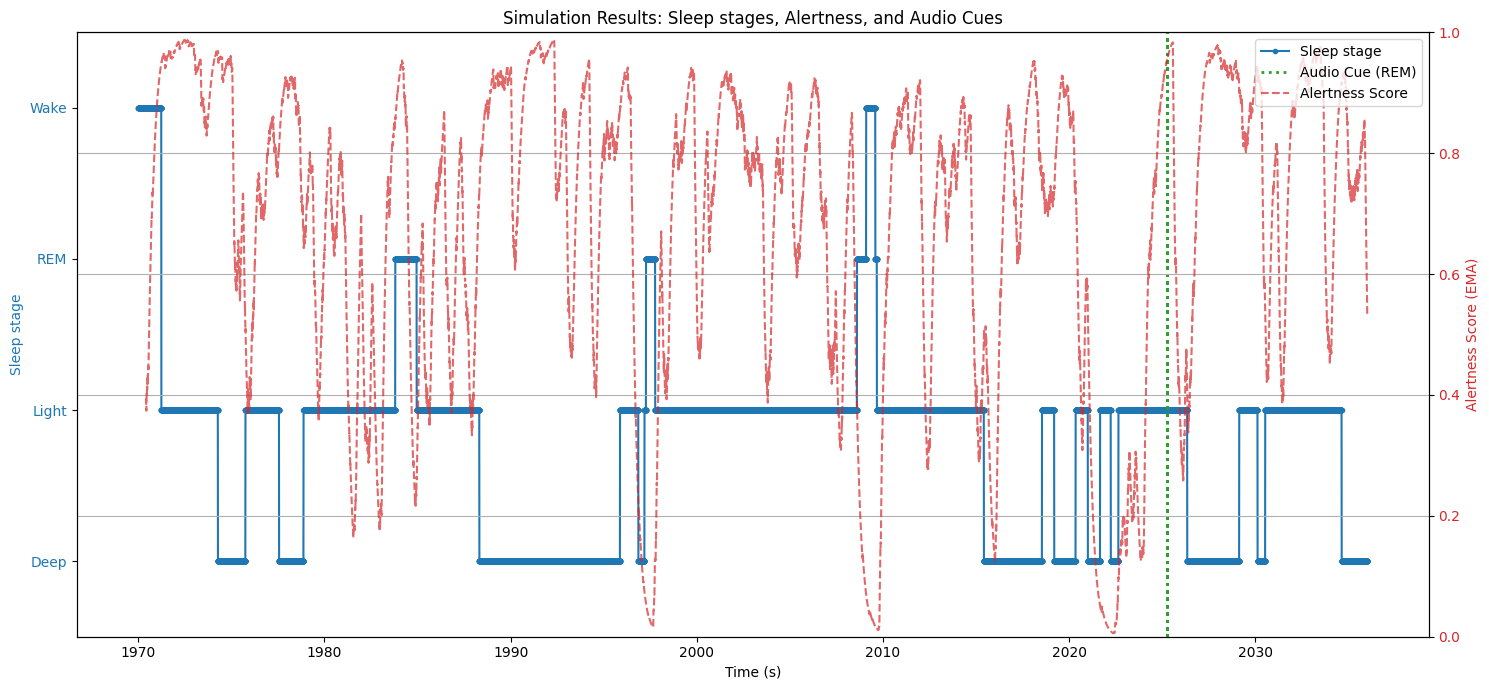

In [12]:
# --- Plot Simulation Results ---
import numpy as np
import matplotlib.pyplot as plt
import os

# Check if simulation data exists in memory from Cell 5
if 'sim_times' in locals() and \
   'sim_timestamps_utc' in locals() and \
   'sim_stages' in locals() and \
   'sim_alertness' in locals() and \
   'sim_cues_events' in locals():

    print("Plotting simulation results directly from memory...")

    # Use the variables directly from the simulation output
    simulation_times_seconds = np.array(sim_times)
    # sim_timestamps_utc_loaded = sim_timestamps_utc # Already datetime objects
    sleep_stages_loaded = sim_stages
    alertness_scores_loaded = np.array(sim_alertness)
    audio_cue_events_loaded = sim_cues_events # List of dicts or datetime objects

    # --- Debug: Print unique stages from the loaded data ---
    unique_stages_in_data = np.unique(sleep_stages_loaded)
    print(f"Unique sleep stages found in loaded data: {unique_stages_in_data}")
    # --- End Debug ---

    # Define the mapping from stage strings to desired y-axis categories and plot values
    # Y-axis categories and their desired order (top to bottom on plot)
    # Wake (plot y=3), REM (plot y=2), Light (plot y=1), Deep (plot y=0)
    y_plot_values_map = {
        'Wake': 3,
        'REM': 2,
        'Light': 1, # Assuming 'Light' covers N1/N2
        'Deep': 0   # Assuming 'Deep' covers N3
        # Add other string mappings if present, e.g., 'N1', 'N2', 'N3' directly
    }

    mapped_sleep_stages_for_plot = []
    for stage_str in sleep_stages_loaded:
        if stage_str in y_plot_values_map:
            mapped_sleep_stages_for_plot.append(y_plot_values_map[stage_str])
        # Handle cases where stage strings might be slightly different (e.g., case sensitivity, or specific N1/N2/N3)
        # Example: if your data has "N1" or "N2" for light sleep:
        # elif stage_str == "N1" or stage_str == "N2":
        #     mapped_sleep_stages_for_plot.append(y_plot_values_map['Light'])
        else:
            print(f"Warning: Unmapped stage string '{stage_str}' found. Will be plotted as NaN.")
            mapped_sleep_stages_for_plot.append(np.nan) # Stage string not in our defined map
    
    # --- Debug: Print a sample of mapped stages ---
    sample_mapped_stages = mapped_sleep_stages_for_plot[:20] # Print first 20 mapped values
    num_nan_stages = np.sum(np.isnan(mapped_sleep_stages_for_plot))
    print(f"Sample of first 20 mapped_sleep_stages_for_plot: {sample_mapped_stages}")
    print(f"Number of NaN values in mapped_sleep_stages_for_plot: {num_nan_stages} out of {len(mapped_sleep_stages_for_plot)}")
    # --- End Debug ---

    fig, ax1 = plt.subplots(figsize=(15, 7))

    color = 'tab:blue'
    ax1.set_xlabel('Time (s)')
    ax1.set_ylabel('Sleep stage', color=color)
    if not np.all(np.isnan(mapped_sleep_stages_for_plot)):
        ax1.plot(simulation_times_seconds, mapped_sleep_stages_for_plot, color=color, linestyle='-', marker='.', label='Sleep stage')
    else:
        print("WARNING: All mapped sleep stages are NaN. Sleep stage line will not be plotted.")
    ax1.tick_params(axis='y', labelcolor=color)
    
    # Set y-ticks and labels according to the keys in y_plot_values_map, ordered as desired
    # The y_plot_values_map already defines the labels for the numeric y values.
    # We want the labels on the y-axis to be 'Wake', 'REM', 'Light', 'Deep' from top to bottom.
    # So, ticks should be [3, 2, 1, 0] and labels ['Wake', 'REM', 'Light', 'Deep']
    sorted_y_labels = sorted(y_plot_values_map.items(), key=lambda item: item[1], reverse=True)
    y_ticks = [item[1] for item in sorted_y_labels]
    y_tick_labels = [item[0] for item in sorted_y_labels]

    ax1.set_yticks(y_ticks)
    ax1.set_yticklabels(y_tick_labels)
    ax1.set_ylim(min(y_ticks) - 0.5, max(y_ticks) + 0.5) # Adjust ylim to give some padding

    ax2 = ax1.twinx()
    color = 'tab:red'
    ax2.set_ylabel('Alertness Score (EMA)', color=color)
    ax2.plot(simulation_times_seconds, alertness_scores_loaded, color=color, linestyle='--', label='Alertness Score', alpha=0.7)
    ax2.tick_params(axis='y', labelcolor=color)
    ax2.set_ylim(0, 1)

    if len(audio_cue_events_loaded) > 0:
        for cue_time in audio_cue_events_loaded:
            ax1.axvline(x=cue_time, color='tab:green', linestyle=':', linewidth=2, label='Audio Cue (REM)' if 'Audio Cue (REM)' not in [l.get_label() for l in ax1.lines] else "")
    
    plt.title('Simulation Results: Sleep stages, Alertness, and Audio Cues')
    fig.tight_layout()
    
    lines, labels = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    if len(audio_cue_events_loaded) > 0 and not any('Audio Cue (REM)' in l for l in labels + labels2):
        from matplotlib.lines import Line2D
        proxy_line = Line2D([0], [0], linestyle=':', color='tab:green', linewidth=2, label='Audio Cue (REM)')
        lines.append(proxy_line)
        labels.append('Audio Cue (REM)')

    ax2.legend(lines + lines2, labels + labels2, loc='upper right')

    plt.grid(True)
    plt.show()

else:
    print("Simulation data not found in memory. Please run Cell 5 first to generate data.")
    print("Variables checked: sim_times, sim_timestamps_utc, sim_stages, sim_alertness, sim_cues_events")